# RL and Advanced DL. Homework #2
<br>

Task text:
<br>

https://docs.google.com/document/d/1laNIbABgIdjLiwHbd0sl0l_A4qGZcuQaOlQNrza82bQ
<br>

In [1]:
import gym

import math
import random
from collections import defaultdict, Counter
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (17, 8)
legend_fontsize = 16

We start with definition of environment for Tic-tac-toe (with arbitrary biard size and number of elements in line to win).

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN, clone=None):
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = clone.n_rows, clone.n_cols, clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def getNumHash(self):
        str_hash = self.getHash()
        return int(str_hash, base=3)

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.board, self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

# I. Q-learning

The first method to try is classic table Q-learning.

Q-functions for crosses and noughts are learned independently for predefined number of game episodes. The order is:
1. run Q-learning for crosses (playing vs opponent with random strategy)
2. run Q-learning for noughts (playing vs opponent with random strategy or vs fitted crosses on previous step)

The quality of the policies is than evaluated on few episodes where number of *wins*, *loses*, *draws* and *misclicks* is calculated.

*Note.* Everywhere after in code I use following notation:
- `s` - current state
- `a` - current action
- `r` - reward
- `s_` - next state
- `a_` - next action

*Note.* `s1` is used for first player state (crosses), `s2` for second (noughts).

*Note.* Current turn `curTurn` equals 1 for player one, -1 for player two.

In [3]:
def init_Q(sigma=1e-3):
    '''Initializes table Q using standard normal distribution'''
    N_POSITIONS = BOARD_SIZE * BOARD_SIZE
    Q = sigma * np.random.randn(3 ** N_POSITIONS, N_POSITIONS)
    return Q


def compute_policy_by_Q(Q, eps=0):
    '''Returns [epsilon] greedy policy from Q-function'''
    if eps == 0:
        return Q.argmax(axis=1)
    N_POSITIONS = BOARD_SIZE * BOARD_SIZE
    eps = np.random.binomial(n=1, p=eps, size=3 ** N_POSITIONS)
    random_actions = np.random.randint(low=0, high=N_POSITIONS, size=3 ** N_POSITIONS)
    return Q.argmax(axis=1) * (1 - eps) + random_actions * eps


def Q_learning_player_one_episode(env, Q1, pi2=None, alpha=0.05, temperature=0.0, gamma=0.9):
    '''
    Run Q-learning ...
    Return updated Q-function and game result:
        1 : "x" won
        0 : draw
        -1: "o" won
    '''
    N_POSITIONS = BOARD_SIZE * BOARD_SIZE
    pi1 = compute_policy_by_Q(Q1)
    env.reset()
    actions = env.getEmptySpaces()

    s = env.getNumHash()
    a = pi1[s] if np.random.rand() > temperature else np.random.randint(N_POSITIONS)
    _, r, done, _ = env.step(actions[a])

    while not done:
        # move of player 2 (opponent)
        s2 = env.getNumHash()
        a2 = np.random.randint(N_POSITIONS) if pi2 is None else pi2[s2]
        action = actions[a2]
        while env.board[action[0], action[1]] != 0:
            a2 = np.random.randint(N_POSITIONS)
            action = actions[a2]
        _, r2, done, _ = env.step(actions[a2])

        # update Q1
        s_ = env.getNumHash()
        Q1[s][a] = Q1[s][a] + alpha * (r + gamma * np.max(Q1[s_]) - Q1[s][a])

        # player 2 (opponent) finished game
        if done:
            return Q1, r2

        # move of player 1
        a = pi1[s_] if np.random.rand() > temperature else np.random.randint(N_POSITIONS)
        _, r, done, _ = env.step(actions[a])
        s = s_
    Q1[s][a] = Q1[s][a] + alpha * (r + gamma * 0 - Q1[s][a])
    return Q1, r


def Q_learning_player_two_episode(env, Q2, pi1=None, alpha=0.05, temperature=0.0, gamma=0.9):
    '''
    Run Q-learning ...
    Return updated Q-function and game result:
        1 : "o" won
        0 : draw
        -1: "x" won
    '''
    N_POSITIONS = BOARD_SIZE * BOARD_SIZE
    pi2 = compute_policy_by_Q(Q2)
    env.reset()
    actions = env.getEmptySpaces()

    # move of player 1 (opponent)
    s1 = env.getNumHash()
    a1 = np.random.randint(N_POSITIONS) if pi1 is None else pi1[s1]
    action = actions[a1]
    while env.board[action[0], action[1]] != 0:
        a1 = np.random.randint(N_POSITIONS)
        action = actions[a1]
    _ = env.step(actions[a1])

    # move of player 2
    s = env.getNumHash()
    a = pi2[s] if np.random.rand() > temperature else np.random.randint(N_POSITIONS)
    _, r, done, _ = env.step(actions[a])
    # reverse reward
    r = r if r == -10 else -r

    while not done:
        # move of player 1 (opponent)
        s1 = env.getNumHash()
        a1 = np.random.randint(N_POSITIONS) if pi1 is None else pi1[s1]
        action = actions[a1]
        while env.board[action[0], action[1]] != 0:
            a1 = np.random.randint(N_POSITIONS)
            action = actions[a1]
        _, r1, done, _ = env.step(actions[a1])

        # update Q2
        s_ = env.getNumHash()
        Q2[s][a] = Q2[s][a] + alpha * (r + gamma * np.max(Q2[s_]) - Q2[s][a])

        # player 1 (opponent) finished game
        if done:
            return Q2, -r1

        # move of player 2
        a = pi2[s_] if np.random.rand() > temperature else np.random.randint(N_POSITIONS)
        _, r, done, _ = env.step(actions[a])
        # reverse reward
        r = r if r == -10 else -r

        s = s_
    Q2[s][a] = Q2[s][a] + alpha * (r + gamma * 0 - Q2[s][a])
    return Q2, r

##########################################
def antagonistic_Q_learning_episode(env, Q1, Q2, alpha=0.05, temperature=0.0, gamma=0.9):
    '''
    Run Q-learning for two Q-functions Q1 and Q2 responding players "x" and "o" for one episode.
    Return updated Q-functions and game result:
        1 : "x" won
        0 : draw
        -1: "o" won
    '''
    N_POSITIONS = BOARD_SIZE * BOARD_SIZE
    pi1 = compute_policy_by_Q(Q1)
    pi2 = compute_policy_by_Q(Q2)
    env.reset()
    actions = env.getEmptySpaces()

    s1 = env.getNumHash()
    a1 = pi1[s1] if np.random.rand() > temperature else np.random.randint(N_POSITIONS)
    _, r1, done, _ = env.step(actions[a1])
    s2 = env.getNumHash()
    a2 = pi2[s2] if np.random.rand() > temperature else np.random.randint(N_POSITIONS)
    _, r2, done, _ = env.step(actions[a2])
    # reverse reward for second player
    r2 = r2 if r2 == -10 else -r2

    while not done:
        s1_ = env.getNumHash()
        a1_ = pi1[s1_] if np.random.rand() > temperature else np.random.randint(N_POSITIONS)
        _, r1_, done, _ = env.step(actions[a1_])

        Q1[s1][a1] = Q1[s1][a1] + alpha * (r1 + gamma * np.max(Q1[s1_]) - Q1[s1][a1])

        # last step of crosses
        if done:
            Q1[s1_][a1_] = Q1[s1_][a1_] + alpha * (r1_ + gamma * 0 - Q1[s1_][a1_])
            result = r1_
            return Q1, Q2, result

        s2_ = env.getNumHash()
        a2_ = pi2[s2_] if np.random.rand() > temperature else np.random.randint(N_POSITIONS)
        _, r2_, done, _ = env.step(actions[a2_])
        # reverse reward for second player
        r2_ = r2_ if r2_ == -10 else -r2_

        Q2[s2][a2] = Q2[s2][a2] + alpha * (r2 + gamma * np.max(Q2[s2_]) - Q2[s2][a2])

        # last step of noughts
        if done:
            Q2[s2_][a2_] = Q2[s2_][a2_] + alpha * (r2_ + gamma * 0 - Q2[s2_][a2_])
            result = -r2_
            return Q1, Q2, result

        s1, a1, r1 = s1_, a1_, r1_
        s2, a2, r2 = s2_, a2_, r2_
    return Q1, Q2, 0


def Q_learning_single_player(env, n_episodes, Q=None, player='x', opponent_policy=None, alpha=0.1, gamma=0.95, temp_factor=1., verbose=False):
    '''
    Run Q-learning for given number of episodes.
    Return learned Q-functions for both players and rewards by episode.
    '''
    assert player in ['x', 'o'], 'player must be either "x" or "o"'
    assert temp_factor > 0
    reward_by_episode = []
    if Q is None:
        Q = init_Q()
    Q_learning_episode = Q_learning_player_one_episode if player == 'x' else Q_learning_player_two_episode
    for cur_episode in tqdm(range(n_episodes), disable=not verbose):
        # exponentially decaying temperature
        temperature = np.exp(-cur_episode / n_episodes * temp_factor)
        Q, r = Q_learning_episode(env, Q, opponent_policy, alpha=alpha, temperature=temperature, gamma=gamma)
        reward_by_episode.append(r)
    return Q, reward_by_episode


##########################################
def antagonistic_Q_learning(env, n_episodes, Q1=None, Q2=None, alpha=0.1, gamma=0.9, temp_factor=1., verbose=False):
    '''
    Run Q-learning for given number of episodes.
    Return learned Q-functions for both players and rewards by episode.
    '''
    assert temp_factor > 0
    reward_by_episode = []
    if Q1 is None:
        Q1 = init_Q()
    if Q2 is None:
        Q2 = init_Q()
    for cur_episode in tqdm(range(n_episodes), disable=not verbose):
        # exponentially decaying temperature
        temperature = np.exp(-cur_episode / n_episodes * temp_factor)
        Q1, Q2, r = antagonistic_Q_learning_episode(env, Q1, Q2, alpha=alpha, temperature=temperature, gamma=gamma)
        reward_by_episode.append(r)
    return Q1, Q2, reward_by_episode


def evaluate_policy_episode(env, pi, player='x', opponent_policy=None):
    '''
    Return reward for episode for given player with given policy.
        1 : player won
        0 : draw
        -1: player lost
    '''
    assert player in ['x', 'o'], 'player must be either "x" or "o"'
    player = 1 if player == 'x' else -1

    N_POSITIONS = BOARD_SIZE * BOARD_SIZE
    env.reset()
    s, actions = env.getNumHash(), env.getEmptySpaces()
    if player == 1:
        a = pi[s]
    else:
        a = np.random.randint(N_POSITIONS) if opponent_policy is None else opponent_policy[s]
        action = actions[a]
        while env.board[action[0], action[1]] != 0:
            a = np.random.randint(N_POSITIONS)
            action = actions[a]
    done = False
    while not done:
        _, r, done, _ = env.step(actions[a])
        if done:
            break
        s = env.getNumHash()

        if player * env.curTurn  == 1:
            a = pi[s]
        else:
            a = np.random.randint(N_POSITIONS) if opponent_policy is None else opponent_policy[s]
            action = actions[a]
            while env.board[action[0], action[1]] != 0:
                a = np.random.randint(N_POSITIONS)
                action = actions[a]
    if r == -10:
        return r
    return r * player


def evaluate_policy(env, pi, n_episodes, player='x', opponent_Q=None, opponent_eps=0.1, verbose=False):
    '''
    Runs game with given player (by policy) and opponent with random strategy.
    '''
    results = defaultdict(int)
    x_reward_to_result = {1: 'Wins', 0: 'Draws', -1: 'Loses', -10: 'Misclicks'}
    opponent_policy = None
    for cur_episode in tqdm(range(n_episodes), disable=not verbose):
        if opponent_Q is not None:
            opponent_policy = compute_policy_by_Q(opponent_Q, eps=opponent_eps) 
        result = evaluate_policy_episode(env, pi, player=player, opponent_policy=opponent_policy)
        results[x_reward_to_result[result]] += 1
    return results

In [4]:
def print_game_results(results):
    n_games = sum(list(results.values()))
    result_names = ['Wins', 'Draws', 'Loses', 'Misclicks']
    df = pd.DataFrame(data={
        'Total games played': result_names,
        str(n_games): [results[name] for name in result_names],
    })
    return df.sort_index()


def plot_rewards_by_episode(rewards_by_episode, title=''):
    rewards_by_episode = np.array(rewards_by_episode)

    wins = np.zeros_like(rewards_by_episode)
    wins[np.where(rewards_by_episode == 1)[0]] = 1
    wins = wins.cumsum()

    loses = np.zeros_like(rewards_by_episode)
    loses[np.where(rewards_by_episode == -1)[0]] = 1
    loses = loses.cumsum()

    plt.figure(figsize=(12,6))
    plt.plot(wins, label='Total wins')
    plt.plot(loses, label='Total loses')
    plt.title(label=f'Sum wins/loses by episode: {title}', fontsize=20)
    plt.legend(fontsize=16)
    plt.show()

To control learning process per episode I use `temperature` - parameter to define whether to take action via argmax of Q-function or sample randomly. I would like to lower this parameter exponentially per episode and `temp_factor` is used here to specify speed of decrease.

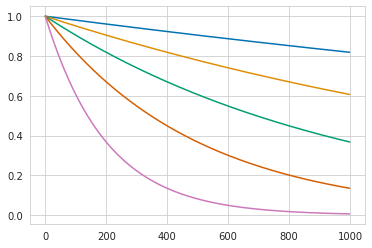

In [5]:
N = 1000
temp_factors = [0.2, 0.5, 1, 2, 5]
for temp_factor in temp_factors:
    plt.plot(np.exp(-np.arange(N) / N * temp_factor))
plt.show()

## 3x3

In [6]:
BOARD_SIZE = 3
env = TicTacToe(BOARD_SIZE, BOARD_SIZE, n_win=3)

Start with statistics of random policy.

In [8]:
random_pi = compute_policy_by_Q(init_Q())
results = evaluate_policy(env, random_pi, n_episodes=10000, player='x')
print_game_results(results)

,Total games played,10000
0,Wins,450
1,Draws,0
2,Loses,1205
3,Misclicks,8345


Fit and watch the statistics: 
- number of wins/loses during learning
- number of game results (wins/draws/loses/misclicks) on evaluation stage

In [64]:
Q1, reward_by_episode_1 = Q_learning_single_player(env, n_episodes=50000, player='x', temp_factor=0.5, verbose=True)
Q2, reward_by_episode_2 = Q_learning_single_player(env, n_episodes=200000, player='o', temp_factor=1., verbose=True)

  0%|          | 0/200000 [00:00<?, ?it/s]

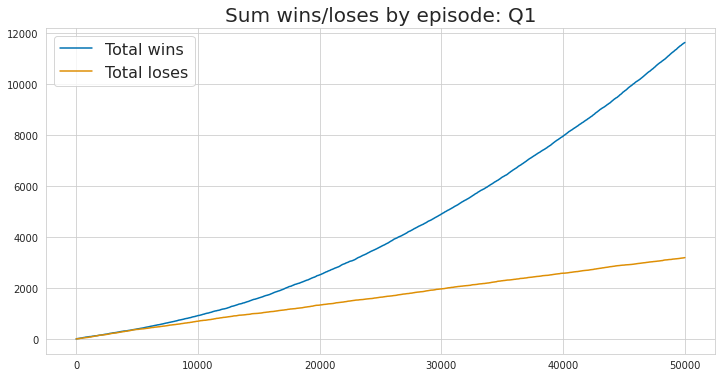

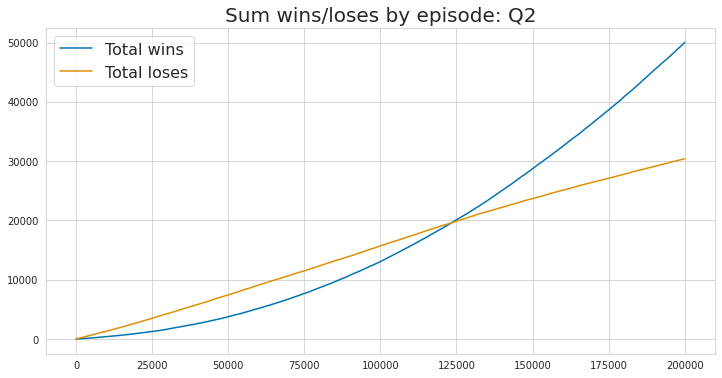

In [66]:
plot_rewards_by_episode(reward_by_episode_1, 'Q1')
plot_rewards_by_episode(reward_by_episode_2, 'Q2')

In [67]:
pi1 = compute_policy_by_Q(Q1)
pi2 = compute_policy_by_Q(Q2)

results1 = evaluate_policy(env, pi1, n_episodes=10000, player='x', verbose=True)
results2 = evaluate_policy(env, pi2, n_episodes=10000, player='o', verbose=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [68]:
print_game_results(results1)

,Total games played,10000
0,Wins,9809
1,Draws,72
2,Loses,119
3,Misclicks,0


In [69]:
print_game_results(results2)

,Total games played,10000
0,Wins,9290
1,Draws,98
2,Loses,612
3,Misclicks,0


Well result - number of wins > 90%, zero misclicks.

A conclusion:
- policy and Q-function for noughts is learned more slowly, because there are more scenarios for random crosses to ruin winning strategy for noughts, thus I need more episodes for noughts to learn 

## 4x4

In [23]:
BOARD_SIZE = 4
env4 = TicTacToe(BOARD_SIZE, BOARD_SIZE, n_win=4)

In [24]:
random_pi = compute_policy_by_Q(init_Q())
results = evaluate_policy(env4, random_pi, n_episodes=10000, player='x')
print_game_results(results)

,Total games played,10000
0,Wins,101
1,Draws,3
2,Loses,101
3,Misclicks,9795


Unfortunately, even 4x4 case is very demanding both in time and memory. I will try to learn strategy for crosses for few number of episodes.

In [7]:
%%time
Q1, reward_by_episode_1 = Q_learning_single_player(env4, n_episodes=1000, player='x', temp_factor=0.5, verbose=True)
# Q2, reward_by_episode_2 = Q_learning_single_player(env4, n_episodes=100, player='o', temp_factor=0.5, verbose=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 30min 36s, sys: 2.89 s, total: 30min 39s
Wall time: 30min 37s


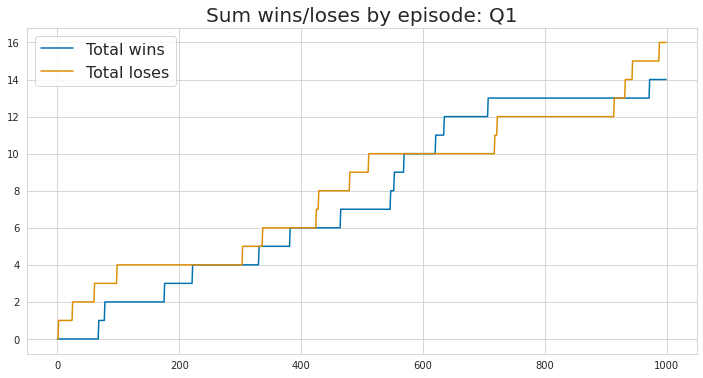

In [8]:
plot_rewards_by_episode(reward_by_episode_1, 'Q1')
# plot_rewards_by_episode(reward_by_episode_2, 'Q2')

In [10]:
pi1 = compute_policy_by_Q(Q1)
# pi2 = compute_policy_by_Q(Q2)

results1 = evaluate_policy(env4, pi1, n_episodes=10000, player='x', verbose=True)
# results2 = evaluate_policy(env4, pi2, n_episodes=1000, player='o', verbose=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [11]:
print_game_results(results1)

,Total games played,10000
0,Wins,176
1,Draws,11
2,Loses,115
3,Misclicks,9698


On the initial stage it is hard to see positive dynamic in learning process, still, number of wins on evaluation for learned policy is a bit larger than for random policy.

# II. DQN

Now we will learn Deep Q-learning Network. 

Experience replay (ReplayMemory) is used to gather experience and sample batches from this memory.

I use convolutional network (ConvNet) as a building block for the model, its usage for this table task is rather promising.

In [9]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [10]:
class ConvNet(nn.Module):
    def __init__(self, n_channels=20, board_size=3):
        super().__init__()
        self.board_size = board_size
        self.conv = nn.Conv2d(in_channels=1, out_channels=n_channels, kernel_size=3, padding=0)
        self.fc = nn.Linear(in_features=n_channels, out_features=board_size*board_size)
    
    def forward(self, x):
        # (bs, board_size, board_size)
        x = self.conv(x.unsqueeze(1))
        x = torch.amax(x, dim=(2, 3))
        x = self.fc(x)
        return x

In [11]:
class TicTacToeDQN:
    def __init__(self, board_size=3, n_win=3):
        self.board_size = board_size
        self.n_positions = board_size * board_size
        self.env = TicTacToe(board_size, board_size, n_win)
        self.model = ConvNet(board_size=board_size)
        self.memory = ReplayMemory(10000)
        self.optimizer = optim.Adam(self.model.parameters(), 0.001)
        self.steps_done = 0
        self.episode_durations = []
        
        self.gamma = 0.8
        self.batch_size = 64
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
        self.num_step = 0


    def select_greedy_action(self, state):
        return self.model(state).data.max(1)[1].view(1, 1)


    def select_action(self, state, temperature):
        sample = random.random()
        self.num_step += 1
        if sample > temperature:
            return self.select_greedy_action(state)
        else:
            return torch.randint(0, self.n_positions, (1,1)) 
    

    def run_episode(self):
        raise NotImplementedError


    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_reward, batch_next_state = zip(*transitions)

        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))

        # считаем значения функции Q
        Q = self.model(batch_state).gather(1, batch_action).reshape([self.batch_size])

        # оцениваем ожидаемые значения после этого действия
        Qmax = self.model(batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

Two similar DQNs are used for crosses and noughts, they differ on stage of gathering experience.

In [12]:
class CrossesTicTacToeDQN(TicTacToeDQN):
    def run_episode(self, temperature=0.9):
        env.reset()
        actions = env.getEmptySpaces()
        num_step = 1

        # move of player 1 (opponent)
        # (1, board_size, board_size)
        s = torch.tensor([env.board], dtype=torch.float32)
        a = self.select_action(s, temperature)
        _, r, done, _ = env.step(actions[a.item()])

        while not done:
            # move of player 2 (opponent)
            num_step += 1
            a2 = np.random.randint(self.n_positions)
            action = actions[a2]
            while env.board[action[0], action[1]] != 0:
                a2 = np.random.randint(self.n_positions)
                action = actions[a2]
            _, r2, done, _ = env.step(actions[a2])

            # store transition
            s_ = torch.tensor([env.board], dtype=torch.float32)
            r = torch.tensor([r], dtype=torch.float32)
            transition = (s, a, r, s_)
            self.memory.store(transition)

            # player 2 (opponent) finished game
            if done:
                r = r2
                break

            # move of player 1
            num_step += 1
            a = self.select_action(s_, temperature)
            _, r, done, _ = env.step(actions[a.item()])
            s = s_

            # player 1 finished game
            if done:
                s_ = torch.tensor([env.board], dtype=torch.float32)
                r = torch.tensor([r], dtype=torch.float32)
                transition = (s, a, r, s_)
                self.memory.store(transition)
                r = r.item()

        self.episode_durations.append(num_step)
        return r


class NoughtsTicTacToeDQN(TicTacToeDQN):
    def run_episode(self, temperature=0.9):
        env.reset()
        actions = env.getEmptySpaces()
        num_step = 2

        # move of player 1 (opponent)
        a1 = np.random.randint(self.n_positions)
        action = actions[a1]
        while env.board[action[0], action[1]] != 0:
            a1 = np.random.randint(N_POSITIONS)
            action = actions[a1]
        _ = env.step(actions[a1])

        # move of player 2
        s = torch.tensor([env.board], dtype=torch.float32)
        a = self.select_action(s, temperature)
        _, r, done, _ = env.step(actions[a.item()])
        # reverse reward
        r = r if r == -10 else -r

        while not done:
            # move of player 1 (opponent)
            num_step += 1
            a1 = np.random.randint(self.n_positions)
            action = actions[a1]
            while env.board[action[0], action[1]] != 0:
                a1 = np.random.randint(self.n_positions)
                action = actions[a1]
            _, r1, done, _ = env.step(actions[a1])

            # store transition
            s_ = torch.tensor([env.board], dtype=torch.float32)
            r = torch.tensor([r], dtype=torch.float32)
            transition = (s, a, r, s_)
            self.memory.store(transition)

            # player 1 (opponent) finished game
            if done:
                r = -r1
                break

            # move of player 2
            num_step += 1
            a = self.select_action(s_, temperature)
            _, r, done, _ = env.step(actions[a.item()])
            # reverse reward
            r = r if r == -10 else -r
            s = s_

            # player 2 finished game
            if done:
                s_ = torch.tensor([env.board], dtype=torch.float32)
                r = torch.tensor([r], dtype=torch.float32)
                transition = (s, a, r, s_)
                self.memory.store(transition)
                r = r.item()

        self.episode_durations.append(num_step)
        return r

Functions to fit and evaluate DQN.

In [13]:
def fit_dqn(env, n_episodes, dqn=None, player='x', temp_factor=1., verbose=False):
    '''
    Run DQN learning for given number of episodes.
    '''
    assert player in ['x', 'o'], 'player must be either "x" or "o"'
    n_episodes_memory = 0
    if dqn is None:
        if player == 'x':
            dqn = CrossesTicTacToeDQN(BOARD_SIZE, N_WIN)
        else:
            dqn = NoughtsTicTacToeDQN(BOARD_SIZE, N_WIN)
        n_episodes_memory = 100
    reward_by_episode = []    
    for cur_episode in range(n_episodes_memory):
        dqn.run_episode()
    for cur_episode in tqdm(range(n_episodes), disable=not verbose):
        dqn.learn()
        # exponentially decaying temperature
        temperature = np.exp(-cur_episode / n_episodes * temp_factor)
        result = dqn.run_episode(temperature)
        reward_by_episode.append(result)
    return dqn, reward_by_episode


def evaluate_dqn_episode(env, dqn, player='x'):
    '''
    Return reward for episode for given player with given policy.
        1 : player won
        0 : draw
        -1: player lost
    '''
    assert player in ['x', 'o'], 'player must be either "x" or "o"'
    player = 1 if player == 'x' else -1

    N_POSITIONS = BOARD_SIZE * BOARD_SIZE
    env.reset()
    actions = env.getEmptySpaces()

    s = torch.tensor([env.board], dtype=torch.float32)
    if player == 1:
        a = dqn.select_greedy_action(s).item()
    else:
        a = np.random.randint(N_POSITIONS)
        action = actions[a]
        while env.board[action[0], action[1]] != 0:
            a = np.random.randint(N_POSITIONS)
            action = actions[a]
    done = False
    while not done:
        _, r, done, _ = env.step(actions[a])
        if done:
            break
        s = torch.tensor([env.board], dtype=torch.float32)

        if player * env.curTurn  == 1:
            a = dqn.select_greedy_action(s).item()
        else:
            a = np.random.randint(N_POSITIONS)
            action = actions[a]
            while env.board[action[0], action[1]] != 0:
                a = np.random.randint(N_POSITIONS)
                action = actions[a]
    if r == -10:
        return r
    return r * player


def evaluate_dqn(env, dqn, n_episodes, player='x', verbose=False):
    '''
    Runs game with given player (by DQN) and opponent with random strategy.
    '''
    results = defaultdict(int)
    x_reward_to_result = {1: 'Wins', 0: 'Draws', -1: 'Loses', -10: 'Misclicks'}
    for cur_episode in tqdm(range(n_episodes), disable=not verbose):
        result = evaluate_dqn_episode(env, dqn, player=player)
        results[x_reward_to_result[result]] += 1
    return results

### Fit and evaluate

*Due to random initialization and sampling sometimes we get different results on evaluation, in some cases strategies do not converge.*

In [14]:
BOARD_SIZE = 3
N_WIN = 3

env = TicTacToe(BOARD_SIZE, BOARD_SIZE, N_WIN)

In [15]:
dqn1, reward_by_episode_dqn1 = fit_dqn(env, 40000, player='x', temp_factor=20., verbose=True)
dqn2, reward_by_episode_dqn2 = fit_dqn(env, 90000, player='o', temp_factor=5., verbose=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if __name__ == '__main__':


  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/90000 [00:00<?, ?it/s]

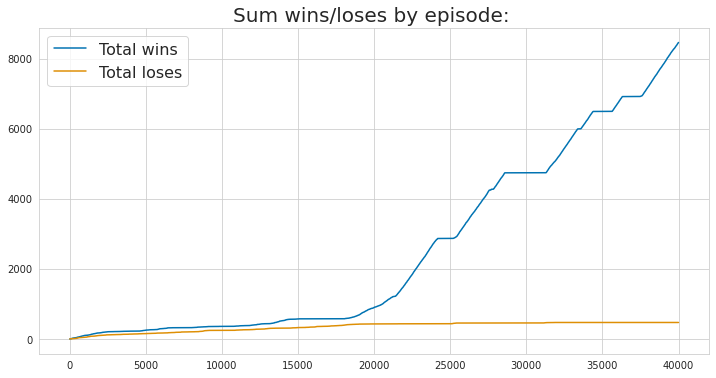

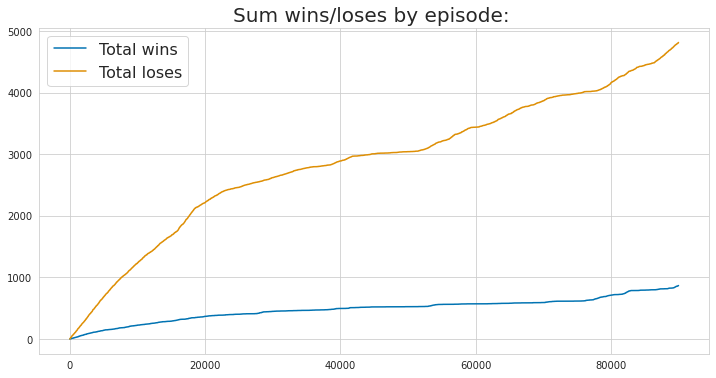

In [16]:
plot_rewards_by_episode(reward_by_episode_dqn1)
plot_rewards_by_episode(reward_by_episode_dqn2)

In [20]:
results_dqn1 = evaluate_dqn(env, dqn1, n_episodes=10000, player='x', verbose=True)
results_dqn2 = evaluate_dqn(env, dqn2, n_episodes=10000, player='o', verbose=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [26]:
print_game_results(results_dqn1)

,Total games played,10000
0,Wins,7713
1,Draws,108
2,Loses,64
3,Misclicks,2115


In [32]:
print_game_results(results_dqn2)

,Total games played,10000
0,Wins,2304
1,Draws,984
2,Loses,1519
3,Misclicks,5193


For this run, strategy for crosses learned much better than the opposing one.

Again, strategy for noughts demands more iterations to reach better quality.